# Malleco data
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('D:/ExperimentsPhD/June_19_24/wasslsp')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = 'D:/ExperimentsPhD/June_19_24/wasslsp/data/'

In [2]:
malleco = pd.read_csv(path_data + 'malleco.csv')

In [3]:
malleco.head(), malleco.columns

(   Year Value
 0  1242 1.343
 1  1243 1.044
 2  1244 1.174
 3  1245 1.068
 4  1246 0.913,
 Index(['Year Value'], dtype='object'))

In [4]:
years = []
values = []
for i in range(malleco.shape[0]):
    years.append(malleco['Year Value'][i][:4])
    values.append(malleco['Year Value'][i][5:])
    
df_malleco = pd.DataFrame({'Year': years, 'Value': values})

In [5]:
df_malleco.head()

,Year,Value
0,1242,1.343
1,1243,1.044
2,1244,1.174
3,1245,1.068
4,1246,0.913


In [6]:
df_malleco['Value'] = pd.to_numeric(df_malleco['Value'])
df_malleco['Year'] = pd.to_numeric(df_malleco['Year'])

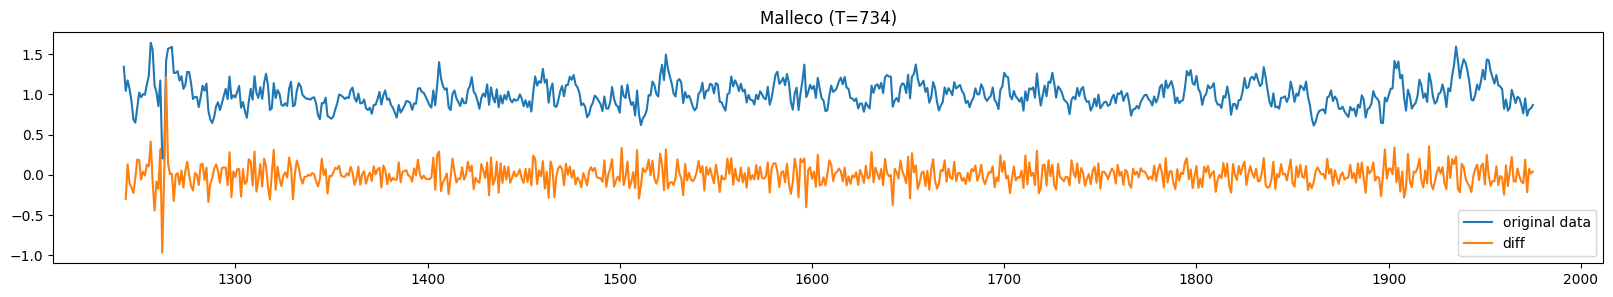

In [7]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_malleco['Year'], df_malleco['Value'], label="original data")
plt.plot(df_malleco['Year'], df_malleco['Value'].diff(), label="diff")
plt.legend()
plt.title("Malleco (T=734)")
plt.show()

In [8]:
df_malleco.shape

(734, 2)

In [9]:
# import pyreadr
# result = pyreadr.read_r(path_data + 'malleco.rda') # also works for Rds, rda
# print(result.keys()) 

In [9]:
df_malleco['Value'].values.reshape(-1, 1).shape

(734, 1)

In [12]:
# df_malleco['Value'].diff()
# values_array = []
# for i in range(df_malleco.shape[0]-1):
    # values_array.append(df_malleco['Value'][i+1] - df_malleco['Value'][i])

In [13]:
# values_array = np.array(values_array)
# values_array.size

In [10]:
np.where(df_malleco['Value'].diff() == np.nan)

(array([], dtype=int64),)

# Nadara-Watson estimator 

$$
h = C \times \frac{1}{T^{\xi}}
$$

In [11]:
# C = 6
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_malleco.shape[0]
d = 1
bandwidth = T **(-0.4 / (d+1)) / 50
X_dict = df_malleco['Value'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_malleco['Value'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat = [np.sum(weights[str(t)] * X_tvar_2) for t in range(T)]

# Nadrawatson on the process not on its diff 

2024/08/27 15:25:46 Saved result in file Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf


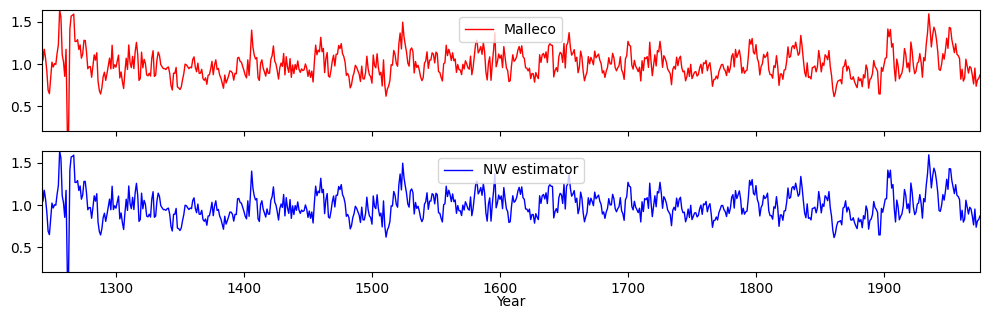

In [12]:
import logging

logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y/%m/%d %H:%M:%S", level=logging.INFO
)

#path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3.3) , sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.02)
# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.facecolor'] = 'black'

output_filename = "Malleco-NW-Gaussian-sp-Uniform-time-C-50.pdf"
# from matplotlib.colors import ListedColormap
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(["#FF0000", "#0000FF"])

ax[0].plot(df_malleco['Year'].values, X_tvar_2, lw=1, label="Malleco", color="#FF0000")  # #, color="r") #, cmap=cm)
ax[0].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[0].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[0].legend(loc='upper center')

ax[1].plot(df_malleco['Year'].values, np.array(m_hat), lw=1, label="NW estimator" , c="#0000FF")#cm_bright[0]) #"orange")
ax[1].set_xlim(min(df_malleco['Year'].values), max(df_malleco['Year'].values))
ax[1].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[1].legend(loc='upper center')
ax[1].set_xlabel("Year")
ax[1].xaxis.set_label_coords(0.5, -0.19)
#plt.savefig(path_fig+output_filename, dpi=300)
plt.tight_layout()
# plt.show()
logging.info("Saved result in file %s" % output_filename)

In [13]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(0.0008914535818807643, 0.0004835809049098816)

In [ ]:
(0.0013243158067462516, 0.0008385242139966689) # 40
(0.0008914535818807643, 0.0004835809049098816) # 50
# 60

In [14]:

T = df_malleco.shape[0]
n_replications = 500
d = 1


X_tvar_2 = np.zeros(T)
X_tvar_2_mean = np.zeros(T)

X_tvar_2_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    sigma_star = lambda u: 0.01
    t = 1
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2[t] = df_malleco['Value'].values[t] + sigma_star(t/T) * epsilon[t]
        X[t] = [X_tvar_2[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2

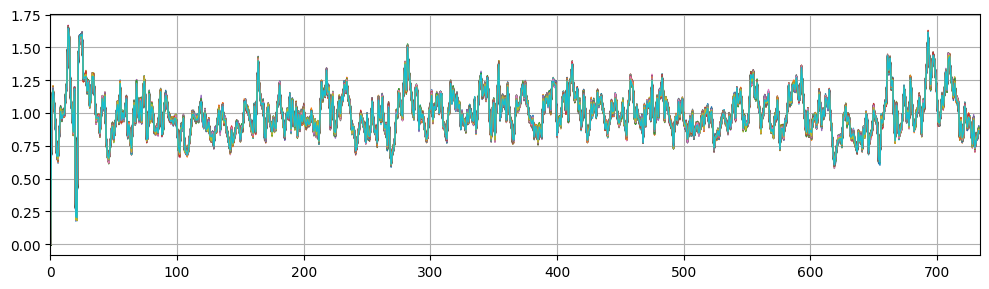

In [15]:
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1)
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    #plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    plt.grid(True)
    #plt.savefig(path_fig+"mean_funciton", dpi=150)
plt.show()

In [108]:
times_t = [150, 200, 250, 300, 350, 400, 450, 500] 
times_T = [T]
n_replications = 500
d = 1

In [109]:
xi = 0.499/ (d+1)
times_T * np.array(times_T)**(-xi) /20

array([7.07416031])

In [110]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvar_2_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [111]:
import torch
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [112]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        sigma_star = lambda u: 0.01
        t = 1
        epsilon = np.random.normal(size=(T))
        X = np.zeros((T,d))
        X_tvar_2_T = np.zeros(T)
        while t <= T-1 :
            X_tvar_2_T[t] = df_malleco['Value'].values[t] + sigma_star(t/T) * epsilon[t]
            
            X[t] = [X_tvar_2_T[t-1]]
            t += 1

        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X


In [113]:
X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [114]:
for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvar_2_replications[f"T:{T}"][replication][t-1]
            X_tvar_2[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = np.array(X_tvar_2[f"t:{t}_T:{T}"])

In [115]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvar_2[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])
        #sns.lineplot(
            #x=X_tvar_2[f"t:{t}_T:{T}"], y=norm_X_tvar_2[f"t:{t}_T:{str(T)}"], lw=2, markers=True,
            #label=f"(t,T)={t, T}",  drawstyle='steps-mid',          
        #)
        #plt.legend()
        #plt.tight_layout()

# space_kernel = "gaussian"; time_kernel = "uniform"

In [116]:
space_kernel = "gaussian" #"silverman"
time_kernel = "uniform" #"tricube"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) #/ 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [117]:
gaussian_kernel

{'T:734': Kernel(T=734, bandwidth=0.5169284012918038, time_kernel='uniform')}

In [118]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t)

In [119]:
n_replications

500

In [120]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [121]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [103]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [122]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            #plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
            ##plt.xlim(-18, 18)
            ##plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            #plt.legend()
            ##plt.tight_layout()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [123]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [124]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [125]:
wass_distances_empirical_meanNW

{'t:150_T:734': 0.34278784959881436,
 't:200_T:734': 0.35532981419872695,
 't:250_T:734': 0.32330513554435847,
 't:300_T:734': 0.3624691888047403,
 't:350_T:734': 0.36943184854141775,
 't:400_T:734': 0.4178464976971652,
 't:450_T:734': 0.3450326190968358,
 't:500_T:734': 0.39060599487564523}